In [52]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [53]:
data = pd.read_csv("all_buildings.csv")
non_residential_buildings = pd.read_csv("non_residential_buildings.csv")

In [54]:
non_residential_buildings

,Unnamed: 0,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,SecondLargestPropertyUseType_ServiceFacility,ThirdLargestPropertyUseType_Commercial,ThirdLargestPropertyUseType_Education,ThirdLargestPropertyUseType_Health,ThirdLargestPropertyUseType_Hospitality,ThirdLargestPropertyUseType_Leisure,ThirdLargestPropertyUseType_None,ThirdLargestPropertyUseType_Other,ThirdLargestPropertyUseType_Residential,ThirdLargestPropertyUseType_ServiceFacility
0,0,47.61220,-122.33799,1.0,12,88434,0,88434,88434.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,47.61317,-122.33393,1.0,11,103566,15064,88502,83880.0,15064.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,47.61393,-122.33810,1.0,41,956110,196718,759392,756493.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,47.61412,-122.33664,1.0,10,61320,0,61320,61320.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,47.61375,-122.34047,1.0,18,175580,62000,113580,123445.0,68009.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,3134,47.62256,-122.32092,1.0,2,140823,59401,81422,89820.0,64000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1436,3136,47.57918,-122.32075,5.0,1,87458,0,87458,41097.0,39772.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1437,3141,47.71864,-122.31200,1.0,1,51400,0,51400,51841.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1438,3144,47.64779,-122.33352,1.0,1,26263,0,26263,26263.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [55]:
data.drop(columns="Unnamed: 0")
non_residential_buildings.drop(columns="Unnamed: 0")

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,...,SecondLargestPropertyUseType_ServiceFacility,ThirdLargestPropertyUseType_Commercial,ThirdLargestPropertyUseType_Education,ThirdLargestPropertyUseType_Health,ThirdLargestPropertyUseType_Hospitality,ThirdLargestPropertyUseType_Leisure,ThirdLargestPropertyUseType_None,ThirdLargestPropertyUseType_Other,ThirdLargestPropertyUseType_Residential,ThirdLargestPropertyUseType_ServiceFacility
0,47.61220,-122.33799,1.0,12,88434,0,88434,88434.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,47.61317,-122.33393,1.0,11,103566,15064,88502,83880.0,15064.0,4622.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,47.61393,-122.33810,1.0,41,956110,196718,759392,756493.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,47.61412,-122.33664,1.0,10,61320,0,61320,61320.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,47.61375,-122.34047,1.0,18,175580,62000,113580,123445.0,68009.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,47.62256,-122.32092,1.0,2,140823,59401,81422,89820.0,64000.0,41014.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1436,47.57918,-122.32075,5.0,1,87458,0,87458,41097.0,39772.0,6275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1437,47.71864,-122.31200,1.0,1,51400,0,51400,51841.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1438,47.64779,-122.33352,1.0,1,26263,0,26263,26263.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [56]:
def predict(model, X, y):
    model = model
    model.fit(X, y)
    model.score(X, y)

    return model.predict(X)

In [57]:
non_residential_buildings.drop("SiteEnergyUse(kBtu)", axis=1)

,Unnamed: 0,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,SecondLargestPropertyUseType_ServiceFacility,ThirdLargestPropertyUseType_Commercial,ThirdLargestPropertyUseType_Education,ThirdLargestPropertyUseType_Health,ThirdLargestPropertyUseType_Hospitality,ThirdLargestPropertyUseType_Leisure,ThirdLargestPropertyUseType_None,ThirdLargestPropertyUseType_Other,ThirdLargestPropertyUseType_Residential,ThirdLargestPropertyUseType_ServiceFacility
0,0,47.61220,-122.33799,1.0,12,88434,0,88434,88434.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,47.61317,-122.33393,1.0,11,103566,15064,88502,83880.0,15064.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,47.61393,-122.33810,1.0,41,956110,196718,759392,756493.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,47.61412,-122.33664,1.0,10,61320,0,61320,61320.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,47.61375,-122.34047,1.0,18,175580,62000,113580,123445.0,68009.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,3134,47.62256,-122.32092,1.0,2,140823,59401,81422,89820.0,64000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1436,3136,47.57918,-122.32075,5.0,1,87458,0,87458,41097.0,39772.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1437,3141,47.71864,-122.31200,1.0,1,51400,0,51400,51841.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1438,3144,47.64779,-122.33352,1.0,1,26263,0,26263,26263.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
y = data["SiteEnergyUse(kBtu)"]
X = np.array(non_residential_buildings.drop("SiteEnergyUse(kBtu)", axis=1)).reshape(
    y.shape[0], 1
)

predictions = predict(linear_model.LinearRegression(), X, y)

plt.scatter(X, y)
plt.plot(X, predictions, c="r")

ValueError: cannot reshape array of size 77760 into shape (2956,1)

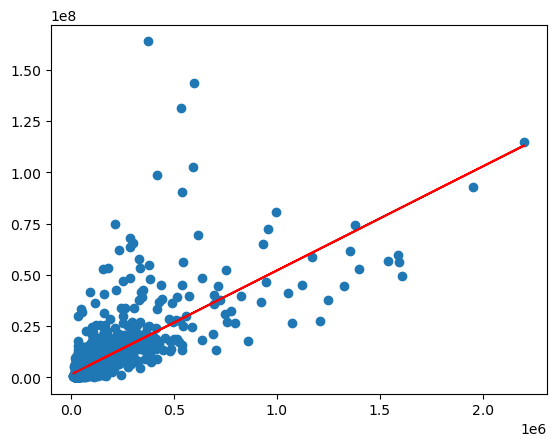

In [ ]:
predict(
    linear_model.LinearRegression(),
    np.array(data["ElectricityUse(Percentage)"]).reshape(y.shape[0], 1),
    y,
)
plt.scatter(X, y)
plt.plot(X, predictions, c="r")